In [1]:
import pandas as pd

data = pd.read_csv("filtered_data.csv");

In [3]:
!pip install catboost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 23.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, accuracy_score
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.ensemble import RandomForestClassifier
import optuna
import warnings
warnings.filterwarnings("ignore")

# 2️⃣ 사용할 컬럼 선택
selected_columns = ['Destination_State', 'Airline', 'Tail_Number', 'Origin_State', 'Estimated_Departure_Time']
X = data[selected_columns].copy()
y = data['Delay']  # 타겟 컬럼명 (데이터셋에 맞게 변경)

# 3️⃣ Label Encoding (범주형 변수 처리)
categorical_cols = ['Destination_State', 'Airline', 'Tail_Number', 'Origin_State']
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    le_dict[col] = le

# 🎯 타겟 변수 Label Encoding 추가
target_le = LabelEncoder()
y = target_le.fit_transform(y)  # 0 = Not_Delayed, 1 = Delayed

# 4️⃣ train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5️⃣ Optuna objective 함수들
def objective_lgb(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 7, 127)
    }
    clf = lgb.LGBMClassifier(**param, random_state=42, n_jobs=-1)
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    score = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='neg_log_loss', n_jobs=-1).mean()
    return -score

def objective_xgb(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0)
    }
    clf = xgb.XGBClassifier(**param, use_label_encoder=False, random_state=42, n_jobs=-1, verbosity=0)
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    score = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='neg_log_loss', n_jobs=-1).mean()
    return -score

def objective_cat(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'loss_function': 'Logloss',
        'verbose': 0
    }
    clf = cb.CatBoostClassifier(**param, random_state=42)
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    score = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='neg_log_loss', n_jobs=-1).mean()
    return -score

# 6️⃣ 모델 학습 및 평가 함수
def train_and_evaluate_best_model(model_name, objective_func=None):
    print(f"\n🔍 [모델] {model_name}")

    # Optuna 튜닝 (RandomForest 제외)
    if model_name != 'RandomForest':
        study = optuna.create_study(direction='minimize')
        study.optimize(objective_func, n_trials=20)
        best_params = study.best_params
        print("Best params:", best_params)
    else:
        best_params = {}

    # 모델 학습
    if model_name == 'LightGBM':
        model = lgb.LGBMClassifier(**best_params, random_state=42, n_jobs=-1)
    elif model_name == 'XGBoost':
        model = xgb.XGBClassifier(**best_params, use_label_encoder=False, random_state=42, n_jobs=-1, verbosity=0)
    elif model_name == 'CatBoost':
        model = cb.CatBoostClassifier(**best_params, random_state=42, verbose=0)
    elif model_name == 'RandomForest':
        model = RandomForestClassifier(random_state=42)
    else:
        raise ValueError("Unknown model")

    model.fit(X_train, y_train)

    # 예측 확률
    y_pred_proba = model.predict_proba(X_test)
    # Not_Delayed = 클래스 0 확률, Delayed = 클래스 1 확률
    y_pred_not_delayed = y_pred_proba[:, 0]
    y_pred_delayed = y_pred_proba[:, 1]

    # Logloss 계산 (전체)
    logloss = log_loss(y_test, y_pred_proba)

    # Accuracy 계산 (0.5 기준)
    y_pred_label = (y_pred_delayed >= 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred_label)

    print(f"✅ {model_name} Log Loss: {logloss:.4f}, Accuracy: {acc:.4f}")

    # 예측 결과 예시 출력
    pred_df = pd.DataFrame({
        'Not_Delayed': y_pred_not_delayed,
        'Delayed': y_pred_delayed
    })
    print(pred_df.head())

# 7️⃣ 모델별 튜닝 및 평가 실행
train_and_evaluate_best_model('LightGBM', objective_lgb)
train_and_evaluate_best_model('XGBoost', objective_xgb)
train_and_evaluate_best_model('CatBoost', objective_cat)
train_and_evaluate_best_model('RandomForest')

[I 2025-06-07 03:24:55,668] A new study created in memory with name: no-name-f985bd1f-f858-4ac8-b020-e9df06216831



🔍 [모델] LightGBM


[I 2025-06-07 03:25:28,460] Trial 0 finished with value: 0.4498088727598677 and parameters: {'n_estimators': 249, 'max_depth': 4, 'learning_rate': 0.14545298705458523, 'num_leaves': 92}. Best is trial 0 with value: 0.4498088727598677.
[I 2025-06-07 03:25:48,592] Trial 1 finished with value: 0.46253093850199617 and parameters: {'n_estimators': 212, 'max_depth': 14, 'learning_rate': 0.21189494467629819, 'num_leaves': 67}. Best is trial 0 with value: 0.4498088727598677.
[I 2025-06-07 03:26:03,394] Trial 2 finished with value: 0.45031809629275465 and parameters: {'n_estimators': 165, 'max_depth': 4, 'learning_rate': 0.23517100250145898, 'num_leaves': 24}. Best is trial 0 with value: 0.4498088727598677.
[I 2025-06-07 03:26:34,444] Trial 3 finished with value: 0.4847056097539881 and parameters: {'n_estimators': 228, 'max_depth': 11, 'learning_rate': 0.2628605115653833, 'num_leaves': 116}. Best is trial 0 with value: 0.4498088727598677.
[I 2025-06-07 03:26:51,229] Trial 4 finished with value:

Best params: {'n_estimators': 249, 'max_depth': 4, 'learning_rate': 0.14545298705458523, 'num_leaves': 92}
[LightGBM] [Info] Number of positive: 134408, number of negative: 28844
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 639
[LightGBM] [Info] Number of data points in the train set: 163252, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.823316 -> initscore=1.538978
[LightGBM] [Info] Start training from score 1.538978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2025-06-07 03:31:49,804] A new study created in memory with name: no-name-9e230aa7-0f53-46c7-9bb7-b5e672f8b082


✅ LightGBM Log Loss: 0.4487, Accuracy: 0.8233
   Not_Delayed   Delayed
0     0.135421  0.864579
1     0.155801  0.844199
2     0.216202  0.783798
3     0.135885  0.864115
4     0.211401  0.788599

🔍 [모델] XGBoost


[I 2025-06-07 03:31:54,637] Trial 0 finished with value: 0.45820696777247294 and parameters: {'n_estimators': 101, 'max_depth': 7, 'learning_rate': 0.24692114458995934, 'subsample': 0.8304361768474995}. Best is trial 0 with value: 0.45820696777247294.
[I 2025-06-07 03:32:14,064] Trial 1 finished with value: 0.5763992058767672 and parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.27280476743512244, 'subsample': 0.848724975524336}. Best is trial 0 with value: 0.45820696777247294.
[I 2025-06-07 03:32:20,584] Trial 2 finished with value: 0.4505116963802896 and parameters: {'n_estimators': 190, 'max_depth': 5, 'learning_rate': 0.10726686524549554, 'subsample': 0.5241991457017029}. Best is trial 2 with value: 0.4505116963802896.
[I 2025-06-07 03:32:30,284] Trial 3 finished with value: 0.45210530803092003 and parameters: {'n_estimators': 270, 'max_depth': 5, 'learning_rate': 0.1463455906016326, 'subsample': 0.8369226203292041}. Best is trial 2 with value: 0.450511696380289

Best params: {'n_estimators': 255, 'max_depth': 5, 'learning_rate': 0.042817147696605336, 'subsample': 0.8558217189748776}


[I 2025-06-07 03:37:58,524] A new study created in memory with name: no-name-3e83ad26-618f-42ea-abce-7aecc4122c41


✅ XGBoost Log Loss: 0.4483, Accuracy: 0.8232
   Not_Delayed   Delayed
0     0.124985  0.875015
1     0.152758  0.847242
2     0.203720  0.796280
3     0.140719  0.859281
4     0.202816  0.797184

🔍 [모델] CatBoost


[I 2025-06-07 03:38:22,479] Trial 0 finished with value: 0.449591003951568 and parameters: {'iterations': 281, 'depth': 4, 'learning_rate': 0.17853759022747798}. Best is trial 0 with value: 0.449591003951568.
[I 2025-06-07 03:38:32,502] Trial 1 finished with value: 0.4498970299752106 and parameters: {'iterations': 140, 'depth': 7, 'learning_rate': 0.09342430594806751}. Best is trial 0 with value: 0.449591003951568.
[I 2025-06-07 03:38:51,797] Trial 2 finished with value: 0.4500409729603452 and parameters: {'iterations': 236, 'depth': 4, 'learning_rate': 0.2667650355652455}. Best is trial 0 with value: 0.449591003951568.
[I 2025-06-07 03:39:13,393] Trial 3 finished with value: 0.45134059644146074 and parameters: {'iterations': 171, 'depth': 10, 'learning_rate': 0.19086609472707844}. Best is trial 0 with value: 0.449591003951568.
[I 2025-06-07 03:39:25,189] Trial 4 finished with value: 0.4495781153681282 and parameters: {'iterations': 140, 'depth': 8, 'learning_rate': 0.12510778634040962

Best params: {'iterations': 127, 'depth': 5, 'learning_rate': 0.2063392173491727}
✅ CatBoost Log Loss: 0.4490, Accuracy: 0.8233
   Not_Delayed   Delayed
0     0.150106  0.849894
1     0.160837  0.839163
2     0.198102  0.801898
3     0.123658  0.876342
4     0.243020  0.756980

🔍 [모델] RandomForest
✅ RandomForest Log Loss: 0.5959, Accuracy: 0.7986
   Not_Delayed  Delayed
0       0.0700   0.9300
1       0.0500   0.9500
2       0.0400   0.9600
3       0.1100   0.8900
4       0.1875   0.8125


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

def visualize_model_performance(model_name, model, X_test, y_test, target_le):
    """
    모델명, 모델 객체, 테스트 데이터셋, 타겟 라벨 인코더를 받아서
    ROC Curve, AUC, F1-score, Confusion Matrix를 시각화
    """
    # 예측 확률과 예측 레이블 계산
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred_label = (y_pred_proba >= 0.5).astype(int)

    # 1️⃣ ROC Curve & AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # 2️⃣ F1-score 출력
    f1 = f1_score(y_test, y_pred_label)
    print(f"📊 {model_name} F1-score: {f1:.4f}")

    # 3️⃣ Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_label)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_le.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.grid(False)
    plt.show()

    # 4️⃣ Classification Report
    print(f"📝 {model_name} Classification Report:")
    print(classification_report(y_test, y_pred_label, target_names=target_le.classes_))

In [13]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.ensemble import RandomForestClassifier

# LightGBM 모델
model_lgbm = lgb.LGBMClassifier(
    n_estimators=249,
    max_depth=4,
    learning_rate=0.14545298705458523,
    num_leaves=92,
    random_state=42,
    n_jobs=-1
)
model_lgbm.fit(X_train, y_train)

# XGBoost 모델
model_xgb = xgb.XGBClassifier(
    n_estimators=255,
    max_depth=5,
    learning_rate=0.042817147696605336,
    subsample=0.8558217189748776,
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
model_xgb.fit(X_train, y_train)

# CatBoost 모델
model_cat = cb.CatBoostClassifier(
    iterations=127,
    depth=5,
    learning_rate=0.2063392173491727,
    random_state=42,
    verbose=0
)
model_cat.fit(X_train, y_train)

# RandomForest 모델
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 134408, number of negative: 28844
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 639
[LightGBM] [Info] Number of data points in the train set: 163252, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.823316 -> initscore=1.538978
[LightGBM] [Info] Start training from score 1.538978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

RandomForestClassifier(random_state=42)

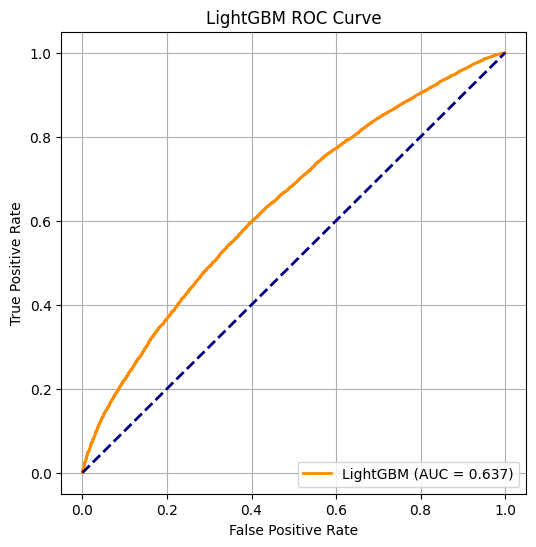

📊 LightGBM F1-score: 0.9030


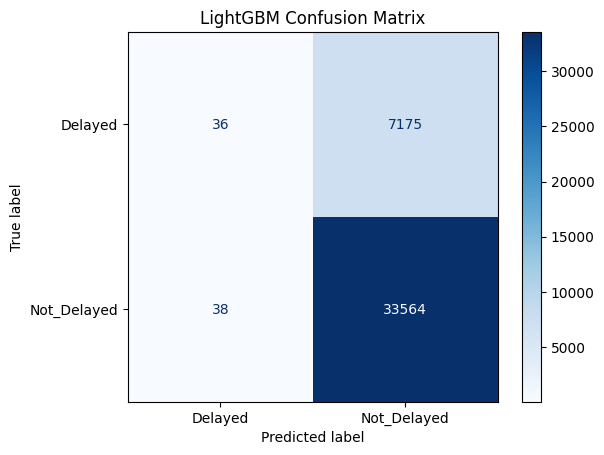

📝 LightGBM Classification Report:
              precision    recall  f1-score   support

     Delayed       0.49      0.00      0.01      7211
 Not_Delayed       0.82      1.00      0.90     33602

    accuracy                           0.82     40813
   macro avg       0.66      0.50      0.46     40813
weighted avg       0.76      0.82      0.75     40813



In [15]:
visualize_model_performance('LightGBM', model_lgbm, X_test, y_test, target_le)

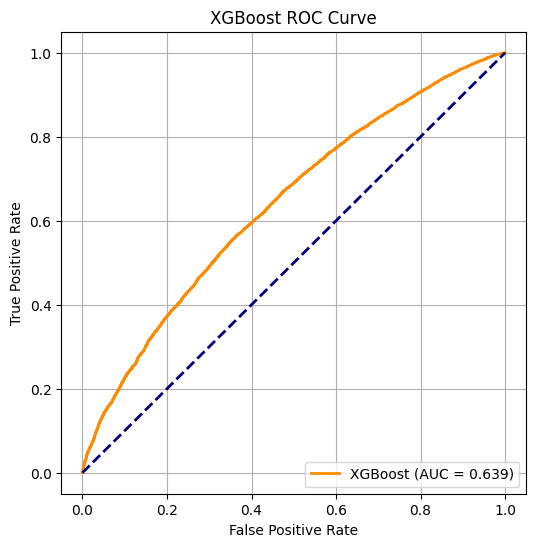

📊 XGBoost F1-score: 0.9030


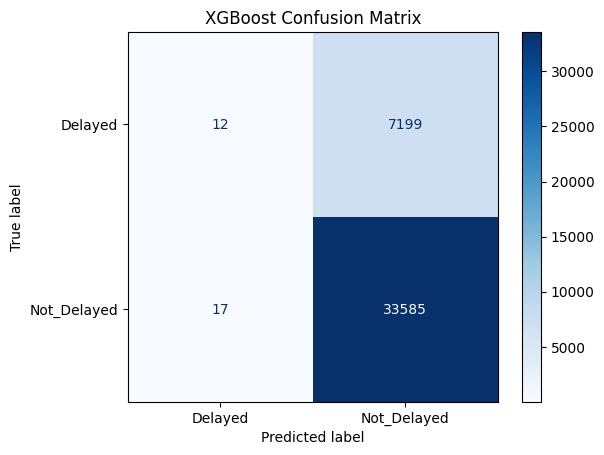

📝 XGBoost Classification Report:
              precision    recall  f1-score   support

     Delayed       0.41      0.00      0.00      7211
 Not_Delayed       0.82      1.00      0.90     33602

    accuracy                           0.82     40813
   macro avg       0.62      0.50      0.45     40813
weighted avg       0.75      0.82      0.74     40813



In [16]:
visualize_model_performance('XGBoost', model_xgb, X_test, y_test, target_le)

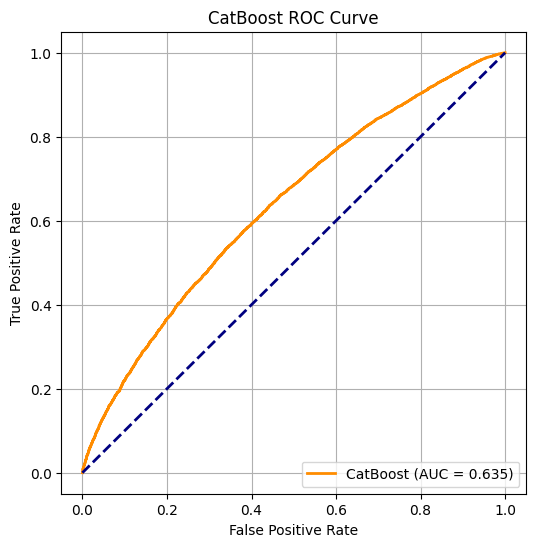

📊 CatBoost F1-score: 0.9030


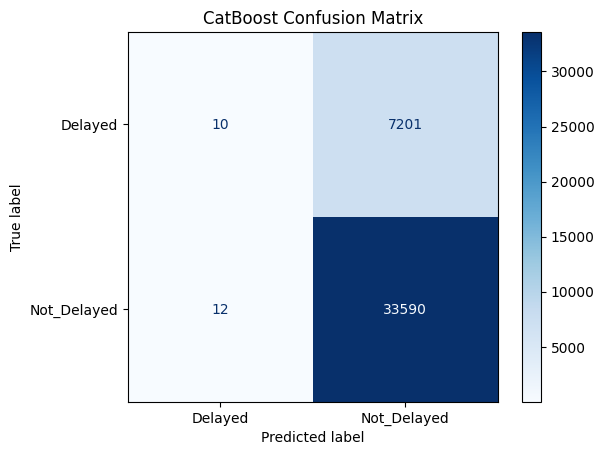

📝 CatBoost Classification Report:
              precision    recall  f1-score   support

     Delayed       0.45      0.00      0.00      7211
 Not_Delayed       0.82      1.00      0.90     33602

    accuracy                           0.82     40813
   macro avg       0.64      0.50      0.45     40813
weighted avg       0.76      0.82      0.74     40813



In [17]:
visualize_model_performance('CatBoost', model_cat, X_test, y_test, target_le)

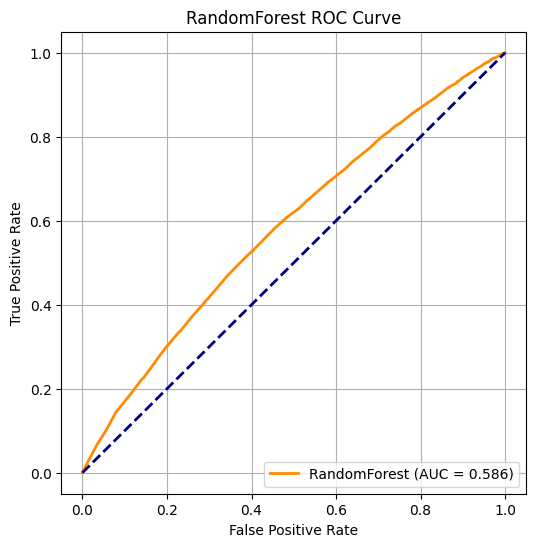

📊 RandomForest F1-score: 0.8862


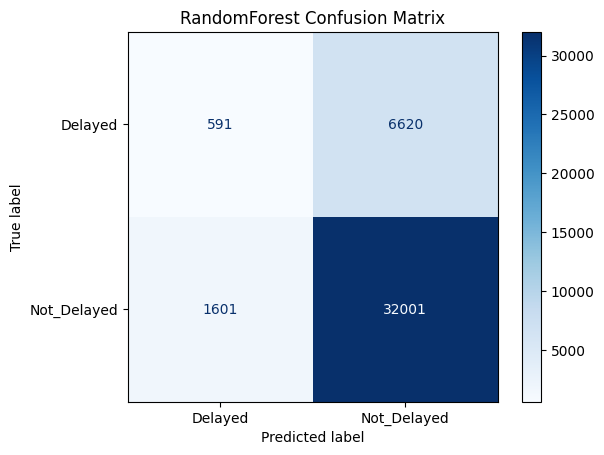

📝 RandomForest Classification Report:
              precision    recall  f1-score   support

     Delayed       0.27      0.08      0.13      7211
 Not_Delayed       0.83      0.95      0.89     33602

    accuracy                           0.80     40813
   macro avg       0.55      0.52      0.51     40813
weighted avg       0.73      0.80      0.75     40813



In [18]:
visualize_model_performance('RandomForest', model_rf, X_test, y_test, target_le)